# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [68]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

%matplotlib inline

In [69]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler, Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.sql.functions import isnull
import time

In [70]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Data Gathering

In [71]:
file_path = 'mini_sparkify_event_data.json'

In [72]:
# spark is an existing SparkSession
df = spark.read.json(file_path)
# Displays the content of the DataFrame to stdout
df.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

In [73]:
# Print the schema in a tree format
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [74]:
# the information for data df

for col in df.columns:
    null_count = df.filter(isnull(df[col])).count()
    empty_count = df.filter(df[col].isin('')).count()
    print(f'With column {col} have {null_count} null values and have {empty_count} empty value')

With column artist have 58392 null values and have 0 empty value
With column auth have 0 null values and have 0 empty value
With column firstName have 8346 null values and have 0 empty value
With column gender have 8346 null values and have 0 empty value
With column itemInSession have 0 null values and have 0 empty value
With column lastName have 8346 null values and have 0 empty value
With column length have 58392 null values and have 0 empty value
With column level have 0 null values and have 0 empty value
With column location have 8346 null values and have 0 empty value
With column method have 0 null values and have 0 empty value
With column page have 0 null values and have 0 empty value
With column registration have 8346 null values and have 0 empty value
With column sessionId have 0 null values and have 0 empty value
With column song have 58392 null values and have 0 empty value
With column status have 0 null values and have 0 empty value
With column ts have 0 null values and have

In [75]:
print(f'The information root dataframe: {df.count()} rows and {len(df.columns)} columns')

The information root dataframe: 286500 rows and 18 columns


In all columns on dataset, i see that have 2 columns is id include to session id and user id. Session id is not null value and empty value. However, userId have empty value. So i will drop any rows have userID == empty

## Data Preprocessing

In [76]:
#Remove null

df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



While the columns userId and sessionId do not contain any null values, several other columns exhibit a significant number of missing values. It is advisable to address and remove these empty values.

In [78]:
df_filter = df.filter(df['userId']!='')

In [79]:
df_filter.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_filter.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Within the same records, all null values are present for the variables related to artists, length, and songs. I've opted not to eliminate these data points as they could still be associated with user behaviors, even in instances where the user is not actively engaged in listening to music.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [80]:
#create column "Downgrade"
df = df.withColumn("Downgrade", F.when(F.col("page") == "Submit Downgrade", 1).otherwise(0))

In [81]:
#create column "Churn"
df = df.withColumn("Churn", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))

In [82]:
#Define window bounds for downgrade 
window_downgrade = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("total_downgrade", F.sum("Downgrade").over(window_downgrade))
#Define window bounds for churn
window_churn = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn("total_churn", F.sum("Churn").over(window_churn))

In [83]:
df.filter(F.col("Churn") == 1).sort("total_churn", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+---------------+-----------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Downgrade|Churn|total_downgrade|total_churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+---------------+-----------+
|  null|Cancelled|    Mason|     M|           10|    Hart|  null| free|  Corpus Christi, TX|   GET|Cancellation Conf...|1533157139000|      174|null|   200|1539318918000|"Mozilla/5.0 (Mac...|   125|        0|    1|              0|          1|
|  null|Cancelled|    Ethan|

In [84]:
df.filter(F.col("Downgrade") == 1).sort("total_downgrade", ascending=False).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+---------------+-----------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|Downgrade|Churn|total_downgrade|total_churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+---------------+-----------+
|  null|Logged In|   Payton|     F|           27|Campbell|  null| paid|Los Angeles-Long ...|   PUT|Submit Downgrade|1529027541000|     1546|null|   307|1541255372000|"Mozilla/5.0 (Win...|    39|        1|    0|              3|          0|
|  null|Logged In|   Payton|     F|         

In [85]:
df.groupBy("Churn").count().show()
df.groupBy("Downgrade").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|286448|
+-----+------+

+---------+------+
|Downgrade| count|
+---------+------+
|        1|    63|
|        0|286437|
+---------+------+



In [86]:
# Number of interactions users 
df.dropDuplicates(['userId']).groupby(['total_churn']).count().sort("total_churn").show()

+-----------+-----+
|total_churn|count|
+-----------+-----+
|          0|  174|
|          1|   52|
+-----------+-----+



In [27]:
gender = df.select("userId", 'gender', 'Churn').distinct()

In [28]:
df_gender = gender.groupby(['Churn', 'gender']).count().sort('Churn').toPandas()


In [87]:
x = 'Churn'
y = 'count'
orders = ["Active","Cancelled"]

In [88]:
df_gender.head()

,Churn,gender,count
0,0,M,121
1,0,F,104
2,0,None,1
3,1,F,20
4,1,M,32


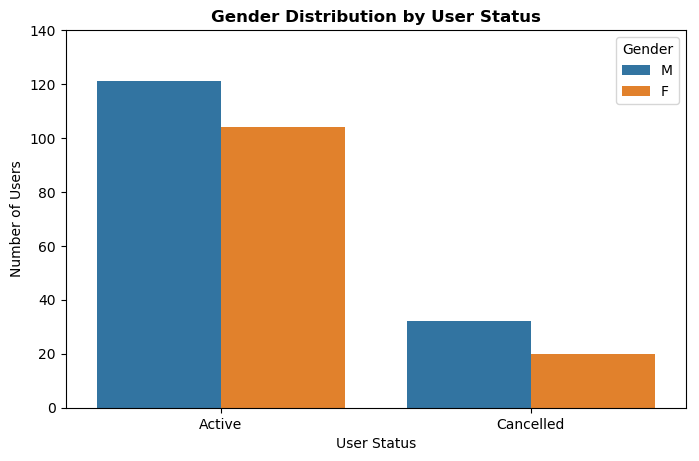

In [89]:
# reference to add name of x label:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100);
sns.barplot(data=df_gender, x=x, y=y, hue='gender');
plt.ylim([0,140]);
plt.title("Gender Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Number of Users");
plt.xticks(np.arange(len(orders)), orders)
plt.legend(title='Gender');

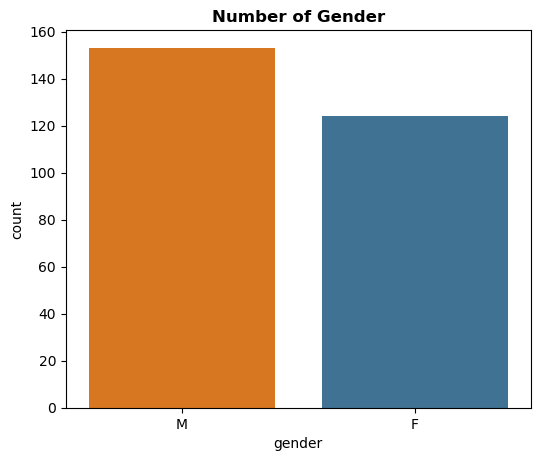

In [90]:
fig, ax = plt.subplots(figsize = (6,5), dpi = 100);
df_gender_count = gender.select('gender').toPandas()
ax = sns.countplot(x='gender', data=df_gender_count, palette=["#f77502", "#3275a1"])
plt.title("Number of Gender", fontweight='bold');

In [91]:
level = df.select('userId', 'level', 'Churn').distinct()

In [92]:
df_level = level.groupby(['Churn', 'level']).count().sort('Churn').toPandas()


In [93]:
x = 'Churn'
y = 'count'
orders = ["Active","Cancelled"]

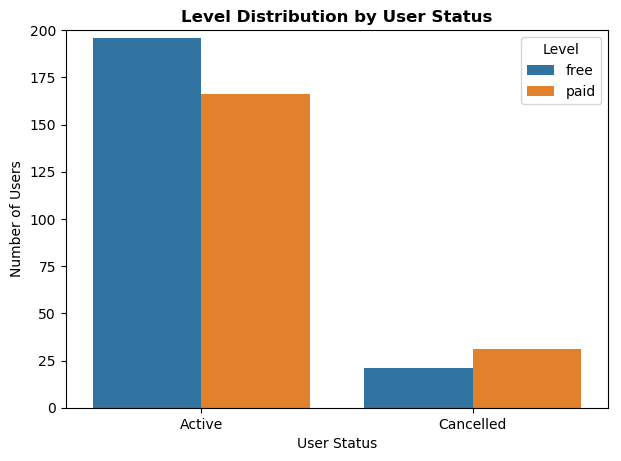

In [94]:
fig, ax = plt.subplots(figsize = (7,5), dpi = 100);
sns.barplot(data=df_level, x=x, y=y, hue='level');
plt.ylim([0,200]);
plt.title("Level Distribution by User Status", fontweight='bold');
plt.xlabel("User Status");
plt.ylabel("Number of Users");
plt.xticks(np.arange(len(orders)), orders)
plt.legend(title='Level');

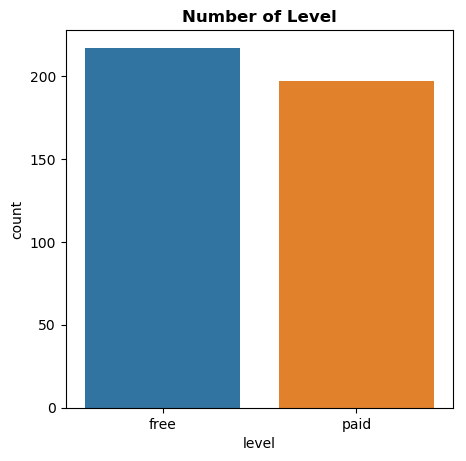

In [95]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100);
df_level_count = level.select('level').toPandas()
ax = sns.countplot(x='level', data=df_level_count)
plt.title("Number of Level", fontweight='bold');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [40]:
# def feature_engineering(dataframe, column:str, convert: bool, value_convert: str, agg_cal: str):
#     """Function use to feature engineering for all columns
#     Input: dataframe to extract
#             column: feature
#             convert: if True -> binary convert else pass
#             value_convert: the value to assign
#     Output: daframe include userId and feature
#     """
#     if convert is True:
#         flag = udf(lambda x: 1 if x == value_convert else 0, IntegerType())
#         dataframe_convert = dataframe.withColumn(column, flag(column))
#         dataframe_fe = dataframe_convert.groupby("userId").agg({column: agg_cal}).withColumnRenamed(f"{agg_cal}(column)", f"{column}_count")
#     else:
#         dataframe_fe = dataframe.groupby("userId").agg({column: agg_cal}).withColumnRenamed(f"{agg_cal}(column)", f"{column}_count")
    
#     return dataframe_fe

In [41]:
#feature engineering

In [42]:
# artist = feature_engineering(df_churn, "artist", False, "", "count")
# gender = feature_engineering(df_churn, "gender", True, "F", "max")
# length = feature_engineering(df_churn, "length", False, "", "sum")
# level  = feature_engineering(df_churn, "level", True, "paid", "max")
# song   = feature_engineering(df_churn, "song", False, "", "count")

In [96]:
# Select relevant features
user_features_df = df.select('userId', 'level', 'gender', 'Churn', 'ts', 'length', 'artist', 'song', 'page')

# Group by userId and calculate user statistics
user_statistics_df = user_features_df.groupBy('userId').agg(
    F.avg('length').alias('avg_song_length'),
    F.countDistinct('artist').alias('total_artist'),
    F.countDistinct('song').alias('total_song'),
    F.count('page').alias('total_session'),
    F.count(F.when(F.col('page') == 'Thumbs Up', True)).alias('total_thumb_up'),
    F.count(F.when(F.col('page') == 'Thumbs Down', True)).alias('total_thumb_down'),
    F.count(F.when(F.col('page') == 'Add Friend', True)).alias('total_add_friend'),
    F.count(F.when(F.col('page') == 'Add to Playlist', True)).alias('total_add_playlist')
)

# Show the first 5 rows of the resulting DataFrame
user_statistics_df.show(5)


+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|userId|   avg_song_length|total_artist|total_song|total_session|total_thumb_up|total_thumb_down|total_add_friend|total_add_playlist|
+------+------------------+------------+----------+-------------+--------------+----------------+----------------+------------------+
|100010|  243.421444909091|         252|       269|          381|            17|               5|               4|                 7|
|200002|242.91699209302305|         339|       378|          474|            21|               6|               4|                 8|
|   125|261.13913750000006|           8|         8|           11|             0|               0|               0|                 0|
|    51|247.88055082899118|        1385|      1854|         2464|           100|              21|              28|                52|
|   124|248.17653659965674|        2232|      3339|         48

In [97]:
label = df.select('userId', F.col('total_churn').alias('label')).dropDuplicates()

In [98]:
data = user_statistics_df.join(label, "userId").drop("userId")
data = data.dropna()

In [99]:
data_final = data.toPandas()
data_final.columns

Index(['avg_song_length', 'total_artist', 'total_song', 'total_session',
       'total_thumb_up', 'total_thumb_down', 'total_add_friend',
       'total_add_playlist', 'label'],
      dtype='object')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Process: 
* Read data from DataFrame and select important features.
* Divide the data into training set, test set and validation set.
* Train the Logistic Regression model and evaluate performance using F1 Score.
* Train the Random Forest model and evaluate performance using F1 Score.
* Train the Logistic SVM model and evaluate performance using F1 Score.
* Train the GBoosting model and evaluate performance using F1 Score.

In [49]:
feature_col = data.columns
feature_col.remove("label")
# split the data to 70% training and 30% testing, set random seed to 42.
train, test = data.randomSplit([0.7, 0.3], seed=42)

In [106]:
def build_predict_model(classifier, param):
    """
    Build a classification model with Cross Validation.

    Parameters:
    classifier: Model
        The classification model to be used.
    param: dict
        Parameters for tuning the model.
    feature_columns: list
        List of feature columns.

    Returns:
    model
        The classification model.
    """
    # Create a vector for the features
    assembler = VectorAssembler(inputCols=feature_col, outputCol="features_vec")
    
    # Normalize the vectors
    scaler = Normalizer(inputCol="features_vec", outputCol="features")
    
    # Build the pipeline
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    # Create a CrossValidator with 5 folds
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    
    return model


In [107]:
def evaluate_predict_model(predictions):
    """
    Evaluate a classification model using the F1 score metric.

    Parameters:
    predictions: DataFrame
        DataFrame containing model predictions.

    Returns:
    None
    """
    # Create a MulticlassClassificationEvaluator for F1 score
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    
    # Calculate and print the F1 score
    f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    print('F1 score: {}'.format(f1_score))


#### Logistic Regression

In [52]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_param = ParamGridBuilder().build()
lr_model = build_predict_model(lr, lr_param)

In [53]:
start_time = time.time()
lr_fit_model = lr_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 700.9195086956024


In [54]:
pred = lr_fit_model.transform(test)

In [55]:
evaluate_predict_model(pred)

F1 score: 0.729470741110249


#### Linear Support Vector Machine

In [56]:
svc = LinearSVC(featuresCol="features", labelCol="label")
svc_param = ParamGridBuilder().build()
svc_model = build_predict_model(svc, svc_param)

In [57]:
start_time = time.time()
svc_fit_model=svc_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 3589.6536536216736


In [58]:
svc_pred = svc_fit_model.transform(test)

In [59]:
evaluate_predict_model(svc_pred)

F1 score: 0.6745037220843673


#### Random Forest

In [60]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_param = ParamGridBuilder().build()
rf_model = build_predict_model(rf, rf_param)

In [61]:
start_time = time.time()
rf_fit_model = rf_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 348.65868496894836


In [62]:
rf_pred = rf_fit_model.transform(test)

In [63]:
evaluate_predict_model(rf_pred)

F1 score: 0.7119964450863039


#### Gradient Boosting

In [64]:
gb = GBTClassifier(featuresCol="features", labelCol="label")
gb_param = ParamGridBuilder().build()
gb_model = build_predict_model(gb, gb_param)

In [65]:
start_time = time.time()
gb_fit_model = gb_model.fit(train)
print("Train time:", time.time() - start_time)

Train time: 1208.8929374217987


In [66]:
gb_pred = gb_fit_model.transform(test)

In [67]:
evaluate_predict_model(gb_pred)

F1 score: 0.6889670902574129


### Reference:
- https://spark.apache.org/docs/1.4.1/ml-features.html
- https://sparkbyexamples.com/machine-learning/confusion-matrix-in-machine-learning/
- https://spark.apache.org/docs/latest/ml-classification-regression.html#classification
- https://www.educative.io/answers/what-is-the-f1-score
- https://stackoverflow.com/questions/41032256/get-same-value-for-precision-recall-and-f-score-in-apache-spark-logistic-regres
- https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.